In [1]:
import matplotlib.pyplot as plt
import numpy as np

from eofs.standard import Eof
from eofs.examples import example_data_path
# import cartopy
import sys,warnings,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from netCDF4 import Dataset,num2date
from mpl_toolkits.basemap import Basemap, cm
from datetime import datetime
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from matplotlib.ticker import MultipleLocator
from scipy import stats

warnings.simplefilter('ignore')

In [2]:
years = np.array([1900,2010])

ncFile = 'sst.mon.mean.nc'
sst = {}
with Dataset(ncFile,'r') as nc:
    sst['lon'] = nc.variables['lon'][:] - 360.
    sst['lat'] = nc.variables['lat'][:]
    
    # Load in the time variable and only retain data from 1900-2000.
    time = nc.variables['time'][:]
    timeUnits = nc.variables['time'].units
    
    tmp = num2date(time,timeUnits,calendar='standard')
    allDates = np.asarray([datetime(d.year,d.month,15) for d in tmp])
    itime = np.where( (allDates>=datetime(years[0],1,1)) & (allDates<datetime(years[1]+1,1,1)) )[0]
    
    sst['date'] = allDates[itime]
    sst['year'] = np.asarray([d.year for d in sst['date']])
    sst['month'] = np.asarray([d.month for d in sst['date']])
    
    # Read in the data.
    tmp = nc.variables['sst'][itime,:,:] # time x lat x lon
    try: sst['data'] = np.where(tmp.mask,np.nan,tmp.data)
    except: sst['data'] = tmp
    
    # Define a land mask for your data. The mask will be NaN for all land points
    # and 1 for all ocean points.
    
    sst['mask'] = np.where(~np.isnan(sst['data'][0,:,:].squeeze()),1,np.nan)
    sst['units'] = nc.variables['sst'].units

In [3]:
ltmFile = 'sst.mon.ltm.nc' 
with Dataset(ltmFile,'r') as nc:
    ltm = nc.variables['sst'][:] # 12 x lat x lon - One for each month

sst['ano'] = np.ones_like(sst['data'])*np.nan
for n,imon in enumerate(range(1,13)):
    x = np.where( (sst['month']==imon) )[0]
    sst['ano'][x,:,:] = sst['data'][x,:,:] - ltm[n,:,:]

In [4]:
# REGION= 'GLOBAL'
REGION = 'TROP PAC'
#REGION = 'N PAC'
#REGION = 'N ATL'

if REGION == 'GLOBAL':
    ilon = np.arange(sst['lon'].size)
    ilat = np.where( abs(sst['lat'])<=75 )[0]
elif REGION == 'TROP PAC':
    ilon = np.where( (sst['lon']>=-240) & (sst['lon']<=-60) )[0]
    ilat = np.where( abs(sst['lat'])<=30 )[0]
elif REGION == 'N PAC':
    ilon = np.where( (sst['lon']>=-240) & (sst['lon']<=-90) )[0]
    ilat = np.where( (sst['lat']>=15) & (sst['lat']<=70) ) [0]
elif REGION == 'N ATL':
    ilon = np.where( sst['lon']>=-90 )[0]
    ilat = np.where( (sst['lat']>=15) & (sst['lat']<=70) )[0]


In [5]:
# TIME = 'MONTHLY'
TIME = 'WINTER'

if TIME == 'MONTHLY':
    itime = np.arange(sst['month'].size)
else:
    itime = np.where( (sst['month']>=10) | (sst['month']<=3) )[0]


In [6]:
subset = sst['ano'][itime,:,:][:,ilat,:][:,:,ilon] #Subset of SST data to analyze.
lon = sst['lon'][ilon] # Only keep the longitude points of interest.
lat = sst['lat'][ilat] # Only keep the latitude points of interest.

lon,lat = np.meshgrid(lon,lat)

T,J,I = subset.shape

In [7]:
def detrend(y):
    '''
    linear regression to detrend
    
    Args:
    -------------------
    :y - numpy.ndarray; target to detrend
    
    Returns:
    -------------------
    :detrend - numpy.ndarray; 
    '''
    
    t= np.arange(len(y))
    E= np.ones((t.size,2))*np.nan
    E[:,0] = t
    E[:,1] = 1
    xhat = np.linalg.inv(np.transpose(E).dot(E)).dot(E.T).dot(y)
    trend = E.dot(xhat)
    detrend= y- trend
    
    return detrend, xhat

In [8]:
# DETREND = True
DETREND = False

if DETREND is True:
    ssta,_ = detrend(subset.reshape((T,-1), order='F')) # Detrend the data. You can use previous code you wrote for this.
else:
    ssta = subset.reshape((T,-1), order='F')

In [9]:
coslat = np.cos(np.deg2rad(lat[:,0]))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(ssta, weights=wgts)

In [10]:
eof1 = solver.eofsAsCorrelation(neofs=1)
pc1 = solver.pcs(npcs=1, pcscaling=1)
solver.varianceFraction()[0]

0.40495294

In [11]:
regressParttern= pc1.T.dot(ssta.reshape(T,-1, order='F'))/T

In [12]:
def visualize(lon, lat, data, stipple=None, **figkwargs):
    """
    Args:
    ---------------
    :figkwargs - dict; {
                        'ylabel': '',
                        'cmap': 'seismic',
                        'cRange': (-1,1),
                        'title': '',
                        'extent': tuple; (llclon, llclat, urclon, urclat)
                        'projection': str; default 'npstere'
                        }
    """
    
    ylabel= figkwargs.get('ylabel', '')
    cmapName= figkwargs.get('cmap', 'seismic')
    cRange= figkwargs.get('cRange', (-1,1))
    title= figkwargs.get('title', '')
    lllon, lllat, urlon, urlat= figkwargs.get('extent', (-180, -90, 180, 90))
    proj= figkwargs.get('projection', 'npstere')
    
    if proj!='npstere':
        rnd= False
    else: rnd=True
    
    
    cmin = cRange[0]; cmax = cRange[1];
    cint = 0.2; clevs = np.round(np.arange(cmin,cmax,cint),1)
    nlevs = len(clevs)-1
    
    plt.gca()
    cmap = plt.get_cmap(name= cmapName,lut=nlevs) 
    m = Basemap(projection='cyl',
            llcrnrlat=-40,urcrnrlat=40,llcrnrlon=-240,urcrnrlon=-60,resolution='l')
    
    x,y = m(lon,lat)
    m.drawcoastlines(linewidth=3)
    m.drawmapboundary(linewidth=2)
#     m.drawmeridians(range(-90, 90, 10))
#     m.drawparallels(range(-360, 0, 20))
    if stipple is not None:
        m.plot(x[stipple], y[stipple],'o',color='Gold',markersize=1.5) #
    cs = m.contourf(x, y, data, cmap=cmap)
    cbar = m.colorbar(cs,size='2%')
    cbar.ax.set_ylabel(ylabel) 
    plt.title(title,name='Arial',weight='bold',size=20)
    
    return m

Text(0, 0.5, 'Index (std)')

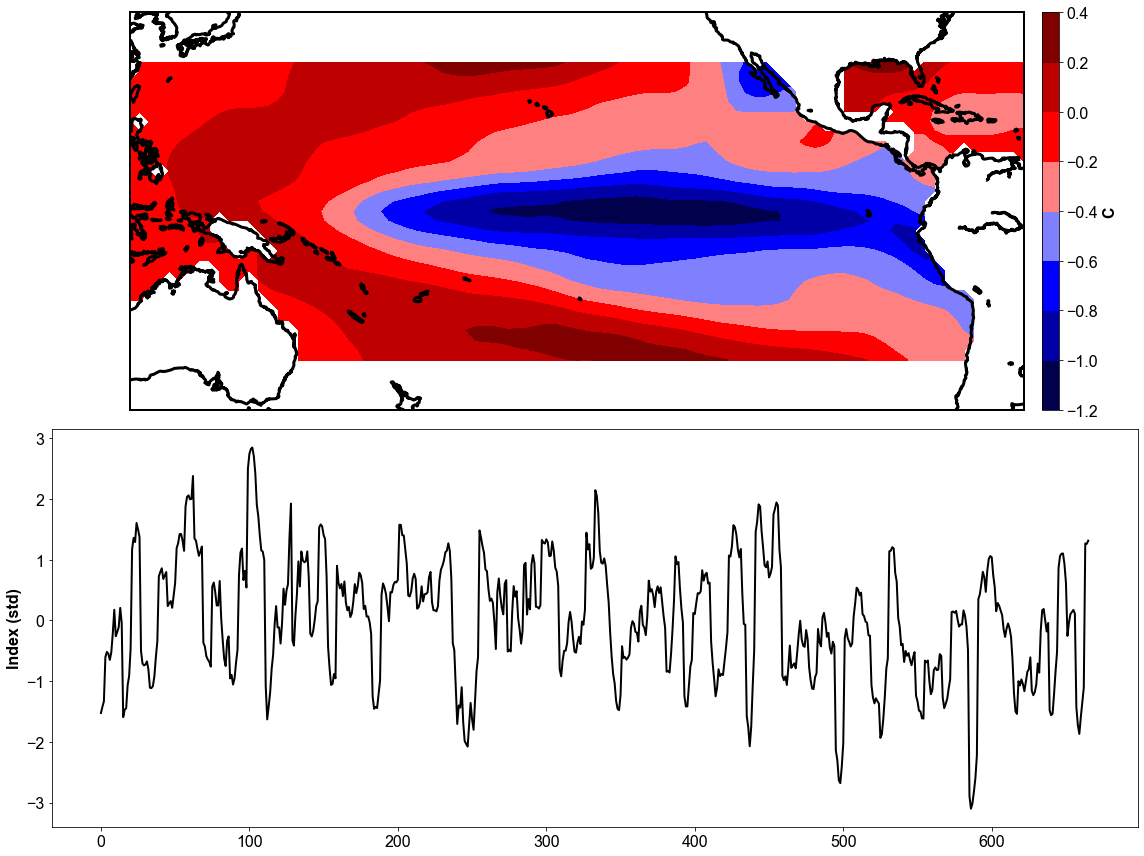

In [13]:
fig= plt.figure(figsize=(16,12))
ax= fig.add_subplot(211)
visualize(lon, lat, regressParttern[0].reshape(31,91,order='F'), extent=(-120,-60,60,60), ylabel='C')
# ax.set_title('%.1f%s of the variance explained by the leading mode'%(varExp[0]*100, str('%')), fontsize=20)
ax= fig.add_subplot(212)
ax.plot( pc1, color='k')
ax.set_ylabel('Index (std)')
plt.tight_layout()